In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import math

In [84]:
df= pd.read_csv("final_dataset.csv")
X=df
boolean_cols=["hasTerrace","hasLivingRoom"]
for col in boolean_cols:    
    df[col] = df[col].map({np.nan: False})
df.isnull().sum()
cols_todrop=df.columns[df.isnull().sum()/df.shape[0]*100>40]
df.drop(columns=cols_todrop, inplace=True)
df.drop(columns=["Unnamed: 0","id","url"], inplace=True)
df=df[~(df["price"].isnull())]
df=df[~(df.isnull().sum(axis=1)>2)]

Flanders=["West Flanders","East Flanders","Antwerp","Flemish Brabant", "Limburg"]
Wallonia=["Walloon Brabant", "Hainaut" , "Liège" , "Namur", "Luxembourg"]
df.loc[df["province"].isin(Flanders), "province"] = "Flanders"
df.loc[df["province"].isin(Wallonia), "province"] = "Wallonia"

In [85]:
df=df[~(df["bedroomCount"].isnull())]
df=df[~(df["facedeCount"].isnull())]
df.drop(columns="buildingConstructionYear", inplace=True)

df["epcScore"]=df["epcScore"].fillna("missing")
df["buildingCondition"]=df["buildingCondition"].fillna("missing")

df["habitableSurface"] = df.groupby("subtype")["habitableSurface"].transform("mean")
df["habitableSurface"]=df["habitableSurface"].astype("float")

df=df.rename(columns={"bathroomCount":"toilet_and_bath"})
df["toilet_and_bath"]=df["toilet_and_bath"].fillna(df["toiletCount"])
df.drop(columns=["toiletCount"], inplace= True)
numeric_cols = df.select_dtypes("number").columns

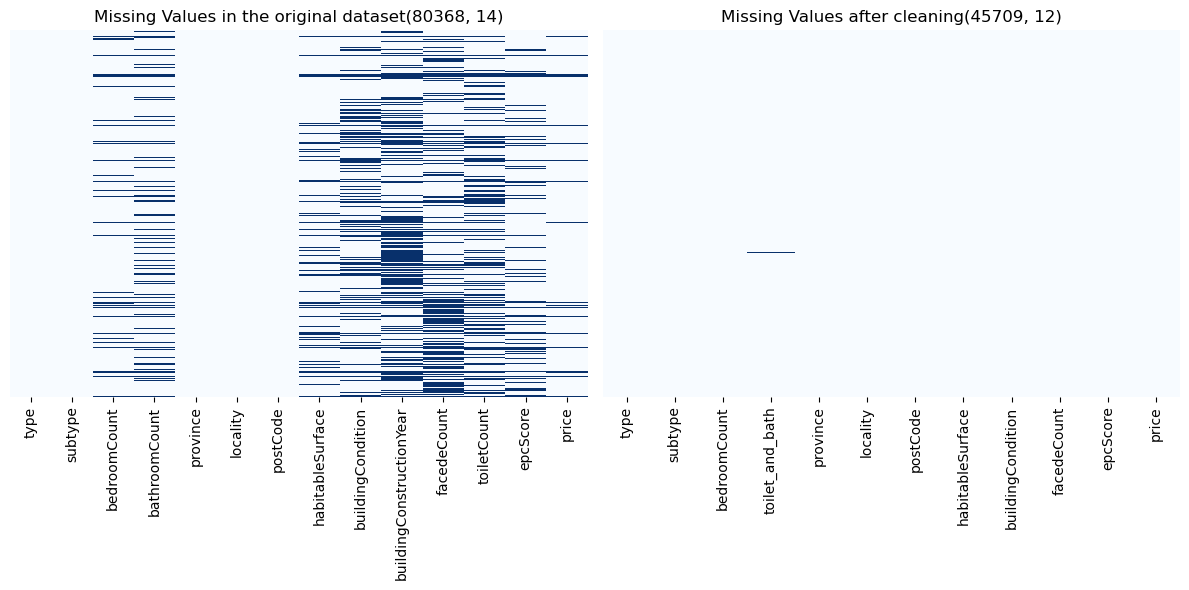

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # combined figsize for both plots
# heatmap of original dataset
sns.heatmap(X.isnull(), cbar=False, yticklabels=False, cmap="Blues", ax=axes[0])
axes[0].set_title(f"Missing Values in the original dataset{X.shape}")
# heatmap after cleaning
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap="Blues", ax=axes[1])
axes[1].set_title(f"Missing Values after cleaning{df.shape}")
plt.tight_layout()
plt.show()

In [87]:
df.dtypes

type                  object
subtype               object
bedroomCount         float64
toilet_and_bath      float64
province              object
locality              object
postCode               int64
habitableSurface     float64
buildingCondition     object
facedeCount          float64
epcScore              object
price                float64
dtype: object

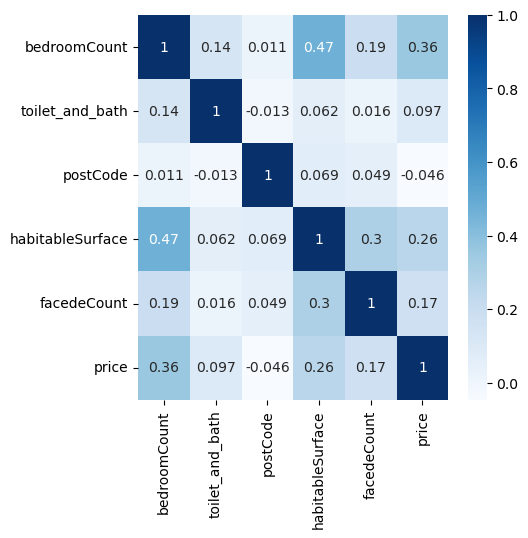

In [88]:
plt.figure(figsize=(5,5))
sns.heatmap(df[numeric_cols].corr(),  cmap="Blues", annot=True)
plt.show()

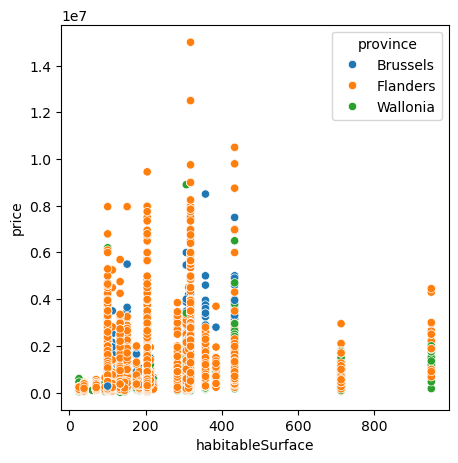

In [98]:
plt.figure(figsize=(5,5))
sns.scatterplot(data=df, x="habitableSurface" , y="price" , hue="province")
plt.show()

In [101]:
cat_cols = df.select_dtypes("object").columns
cat_cols

Index(['type', 'subtype', 'province', 'locality', 'buildingCondition',
       'epcScore'],
      dtype='object')

In [ ]:
cat_cols = df.select_dtypes("object").columns
cat_cols
plt.figure(figsize=(8,8))
for i,  col in enumerate(cat_cols):
    if df[col].nunique()<25:
        sns.barplot(data= cat_cols,x=col,y="price", hue=col)
        plt.title(f"price vs {col}")
        plt.xlabel(col)
        plt.ylabel('Price')
        plt.xticks(rotation=90)
        plt.show()

In [ ]:
#for col in numeric_cols:
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=col, hue="province", multiple="stack", kde=True)
    plt.title(f"Distribution of {col} by Province")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend(title="Province")
    plt.show()

In [ ]:
inlier_mask = pd.Series(True, index=df.index)
for col in numeric_cols:
    if df[col].dtype == "float64" or df[col].dtype == "int64": # Check for any numeric dtype
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_fence = q3 + 1.5 * iqr
        lower_fence = q1 - 1.5 * iqr
        col_inlier_mask = (df[col] >= lower_fence) & (df[col] <= upper_fence)

        inlier_mask = inlier_mask & col_inlier_mask
    else:
        print(f"Skipping non-numeric column: {col}")
df_cleaned = df[inlier_mask].copy()
print(df_cleaned.shape)


DataFrame after removing rows with outliers:
            type      subtype  bedroomCount  toilet_and_bath  province  \
0      APARTMENT    APARTMENT           2.0              1.0  Brussels   
2      APARTMENT    APARTMENT           2.0              1.0  Brussels   
4      APARTMENT  FLAT_STUDIO           1.0              1.0  Brussels   
5      APARTMENT    APARTMENT           2.0              1.0  Brussels   
9      APARTMENT    APARTMENT           1.0              1.0  Brussels   
...          ...          ...           ...              ...       ...   
80358  APARTMENT    APARTMENT           2.0              2.0  Flanders   
80359  APARTMENT    APARTMENT           3.0              1.0  Flanders   
80360  APARTMENT    APARTMENT           3.0              2.0  Flanders   
80363      HOUSE        VILLA           3.0              1.0  Flanders   
80364  APARTMENT    APARTMENT           3.0              1.0  Brussels   

         locality  postCode  habitableSurface buildingCondition  

In [ ]:
for col in numeric_cols:
    if df[col].dtypes == "float64":
        q1=df[col].quantile(0.25)
        q3=df[col].quantile(0.75)
        print(q1, q3)
        iqr=q3-q1
        upper_fence=q3+1.5*iqr
        lower_fence=q1-1.5*iqr
        df=df[(df[col]>=lower_fence) & (numeric_cols[col]<=upper_fence)]
       
df

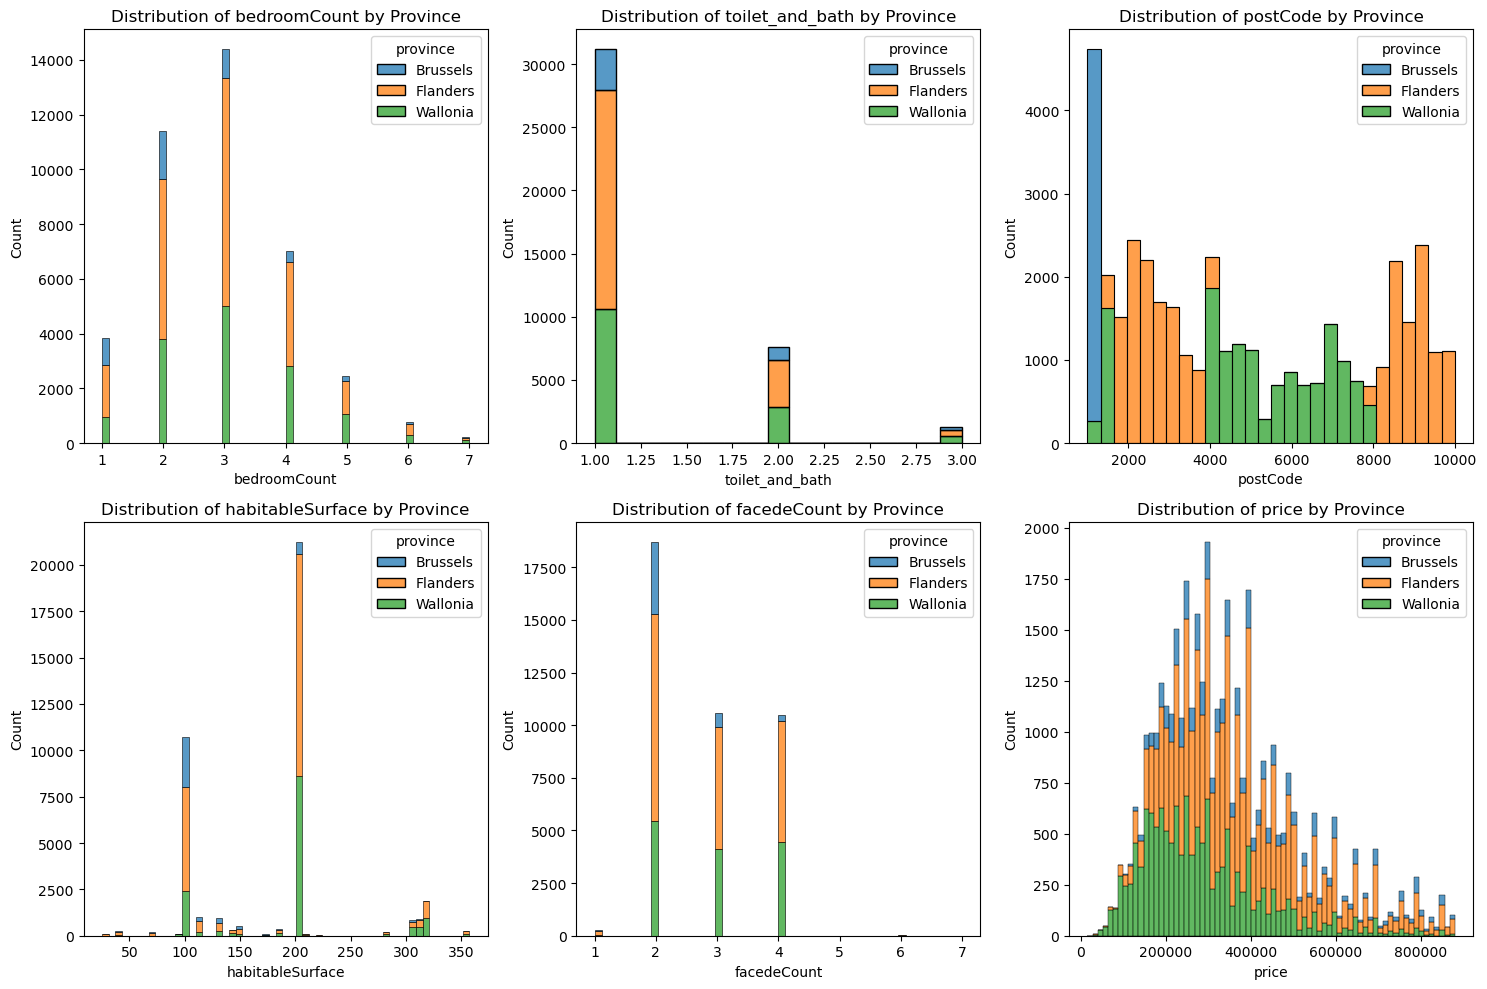

In [116]:
num_plots = len(numeric_cols)
num_rows = 2
# Calculate number of columns needed based on the number of plots and desired rows
num_cols_in_grid = math.ceil(num_plots / num_rows)

# Create the figure and a grid of subplots
# Adjust figsize dynamically based on the number of columns to ensure plots are readable
fig, axes = plt.subplots(num_rows, num_cols_in_grid, figsize=(5 * num_cols_in_grid, 5 * num_rows))

# Flatten the axes array if it's 2D, to easily iterate through individual subplots.
# Handle the case where there's only one plot (axes won't be an array then).
if num_plots == 1:
    axes = [axes] # Make it iterable
elif num_rows > 1 and num_cols_in_grid > 1:
    axes = axes.flatten() # Flatten for easy 1D iteration

# Loop through each numeric column and plot its histogram on a subplot
for i, col in enumerate(numeric_cols):
    if i < len(axes): # Ensure we don't try to plot beyond the available subplots
        ax = axes[i] # Get the current subplot axis
        sns.histplot(data=df_cleaned, x=col, hue="province", multiple="stack", ax=ax)# kde=True,
        ax.set_title(f"Distribution of {col} by Province")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")

        # Place the legend only on the first subplot to avoid clutter
        '''if i == 0:
            ax.legend(title="Province")
        else:
            # Remove legend from subsequent plots if sns.histplot adds it by default
            if ax.get_legend() is not None:
                ax.get_legend().remove()'''

# Hide any unused subplots (if num_plots is less than num_rows * num_cols_in_grid)
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j]) # Delete unused axes

plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show()

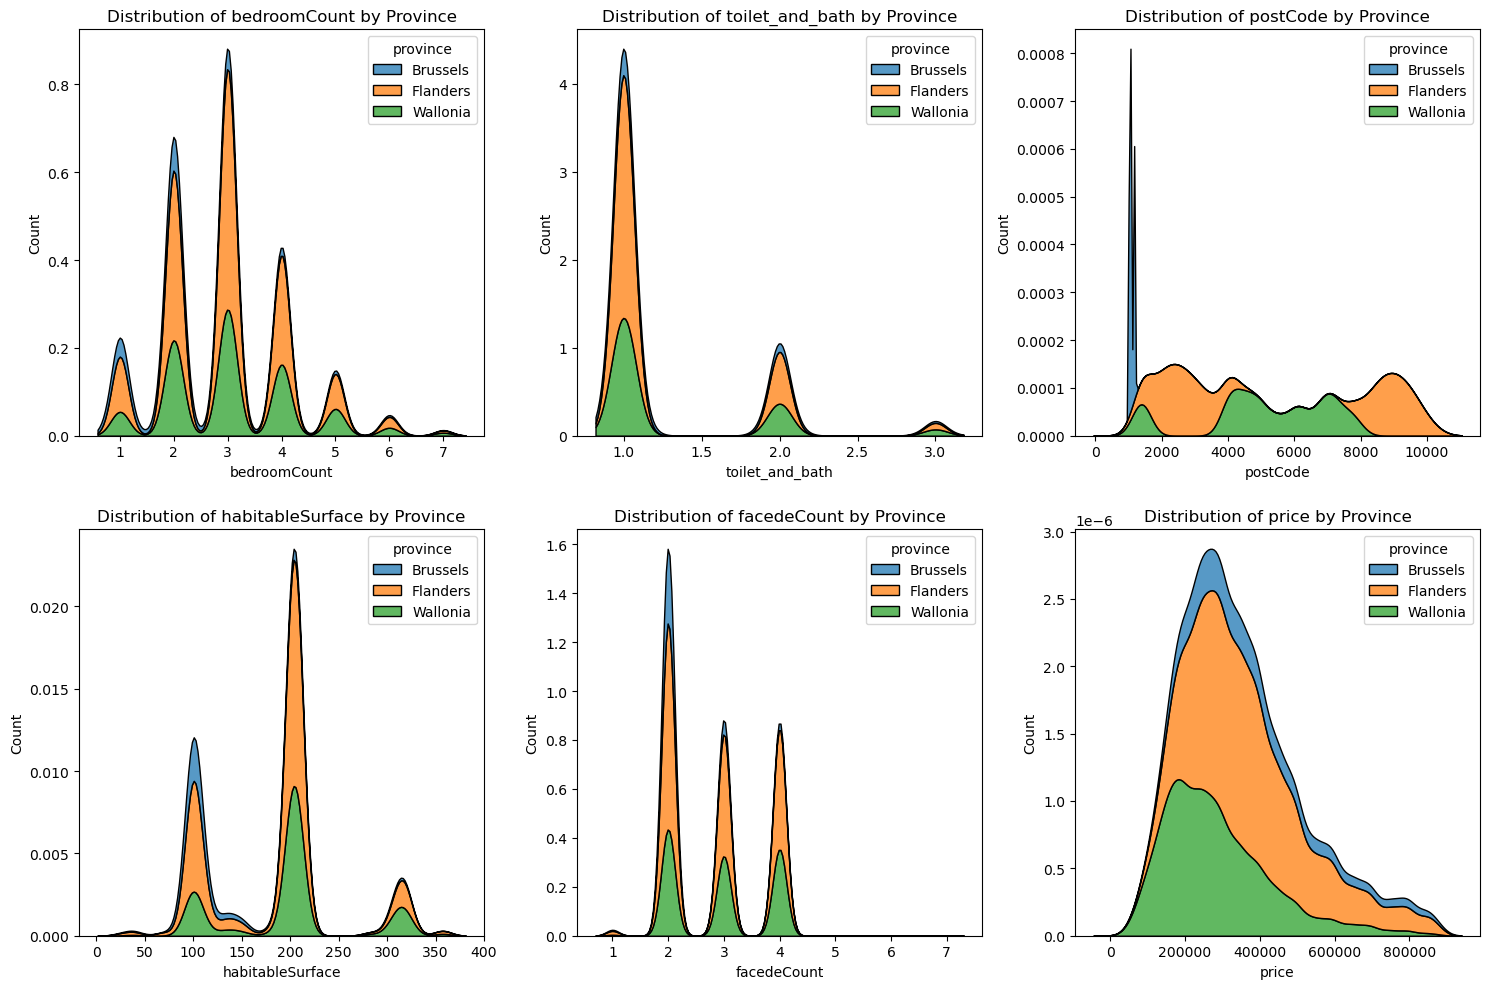

In [122]:
num_plots = len(numeric_cols)
num_rows = 2
# Calculate number of columns needed based on the number of plots and desired rows
num_cols_in_grid = math.ceil(num_plots / num_rows)

# Create the figure and a grid of subplots
# Adjust figsize dynamically based on the number of columns to ensure plots are readable
fig, axes = plt.subplots(num_rows, num_cols_in_grid, figsize=(5 * num_cols_in_grid, 5 * num_rows))

# Flatten the axes array if it's 2D, to easily iterate through individual subplots.
# Handle the case where there's only one plot (axes won't be an array then).
if num_plots == 1:
    axes = [axes] # Make it iterable
elif num_rows > 1 and num_cols_in_grid > 1:
    axes = axes.flatten() # Flatten for easy 1D iteration

# Loop through each numeric column and plot its histogram on a subplot
for i, col in enumerate(numeric_cols):
    if i < len(axes): # Ensure we don't try to plot beyond the available subplots
        ax = axes[i] # Get the current subplot axis
        sns.kdeplot(data=df_cleaned, x=col, hue="province", multiple="stack", ax=ax)# kde=True,
        ax.set_title(f"Distribution of {col} by Province")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")

        # Place the legend only on the first subplot to avoid clutter
        '''if i == 0:
            ax.legend(title="Province")
        else:
            # Remove legend from subsequent plots if sns.histplot adds it by default
            if ax.get_legend() is not None:
                ax.get_legend().remove()'''

# Hide any unused subplots (if num_plots is less than num_rows * num_cols_in_grid)
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j]) # Delete unused axes

plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show()

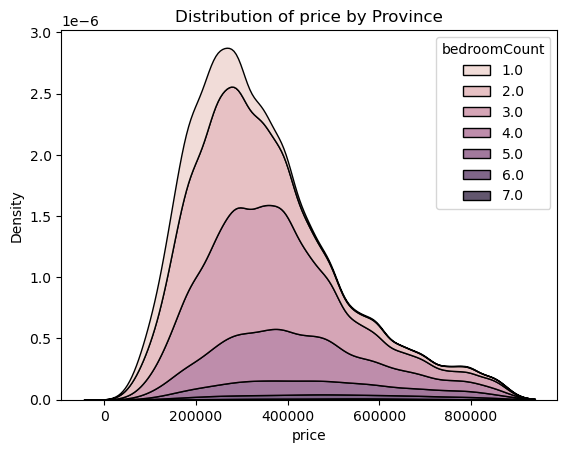

In [129]:
sns.kdeplot(data=df_cleaned, x="price", hue="bedroomCount",  multiple="stack")
plt.title(f"Distribution of price by Province")
plt.show()

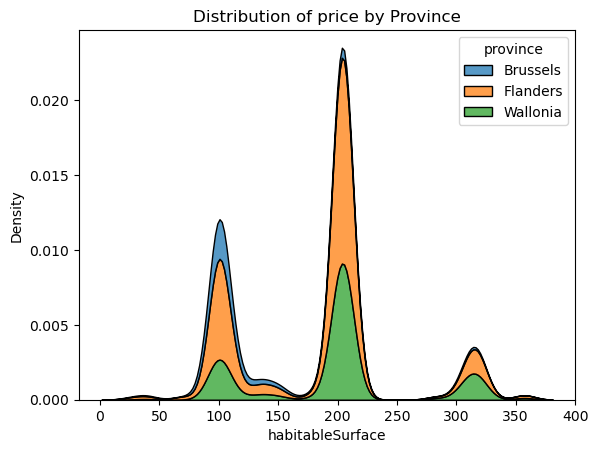

In [130]:
sns.kdeplot(data=df_cleaned, x="habitableSurface", hue="province",  multiple="stack")
plt.title(f"Distribution of price by Province")
plt.show()

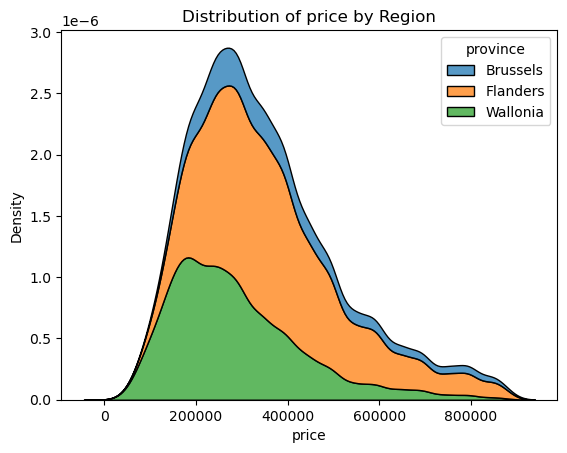

In [155]:
sns.kdeplot(data=df_cleaned, x="price", hue="province",  multiple="stack")
plt.title(f"Distribution of price by Region")
plt.show()

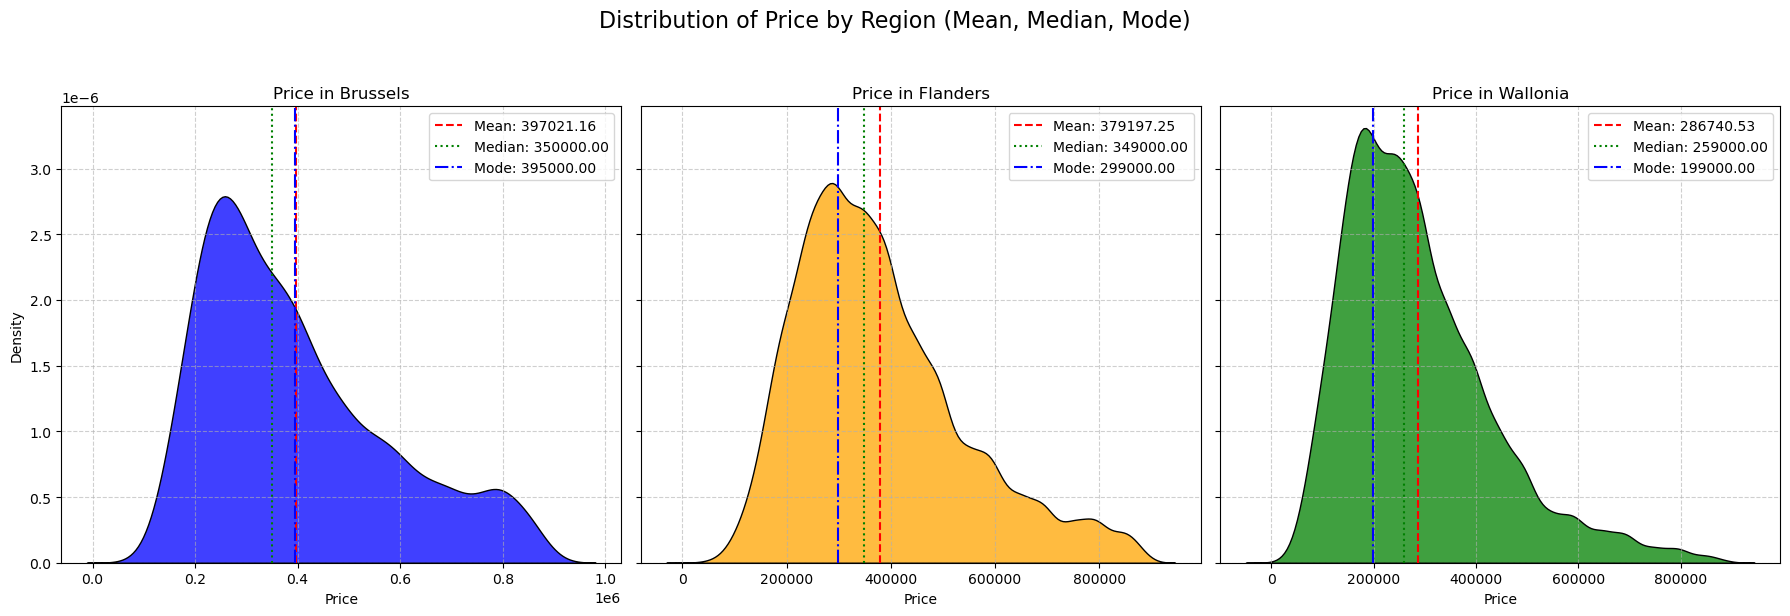

In [156]:
unique_provinces = df_cleaned['province'].unique()
num_provinces = len(unique_provinces)

# Define a list of colors for the KDE plots
# If you have more than 3 provinces, you'll need to add more colors here
kde_colors = ['blue', 'orange', 'green']

# Create a figure and a set of subplots arranged in a single row
fig, axes = plt.subplots(1, num_provinces, figsize=(num_provinces * 6, 6), sharey=True)

# Ensure 'axes' is an array even if there's only one subplot
if num_provinces == 1:
    axes = [axes]

# Iterate through each province and create a subplot
for i, province in enumerate(unique_provinces):
    ax = axes[i] # Select the current subplot
    current_kde_color = kde_colors[i % len(kde_colors)] # Cycle through colors if more provinces than colors

    # Filter data for the current province
    province_data = df_cleaned[df_cleaned['province'] == province]

    # Calculate the mean, median, and mode price for the current province
    mean_price = province_data['price'].mean()
    median_price = province_data['price'].median()
    mode_price = province_data['price'].mode()[0] if not province_data['price'].mode().empty else None

    # Create the KDE plot on the current subplot with the specified color
    # Note: 'color' argument for kdeplot sets the line color and fill color by default
    sns.kdeplot(data=province_data, x="price", multiple="stack", fill=True, ax=ax, color=current_kde_color)

    # Add vertical lines for mean, median, and mode to the current subplot
    ax.axvline(mean_price, color='red', linestyle='--', label=f'Mean: {mean_price:.2f}')
    ax.axvline(median_price, color='green', linestyle=':', label=f'Median: {median_price:.2f}')
    if mode_price is not None:
        ax.axvline(mode_price, color='blue', linestyle='-.', label=f'Mode: {mode_price:.2f}')

    # Set title and labels for the current subplot
    ax.set_title(f"Price in {province}")
    ax.set_xlabel("Price")
    if i == 0:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel("")

    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

# Add a super title for the entire figure
fig.suptitle("Distribution of Price by Region (Mean, Median, Mode)", y=1.02, fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

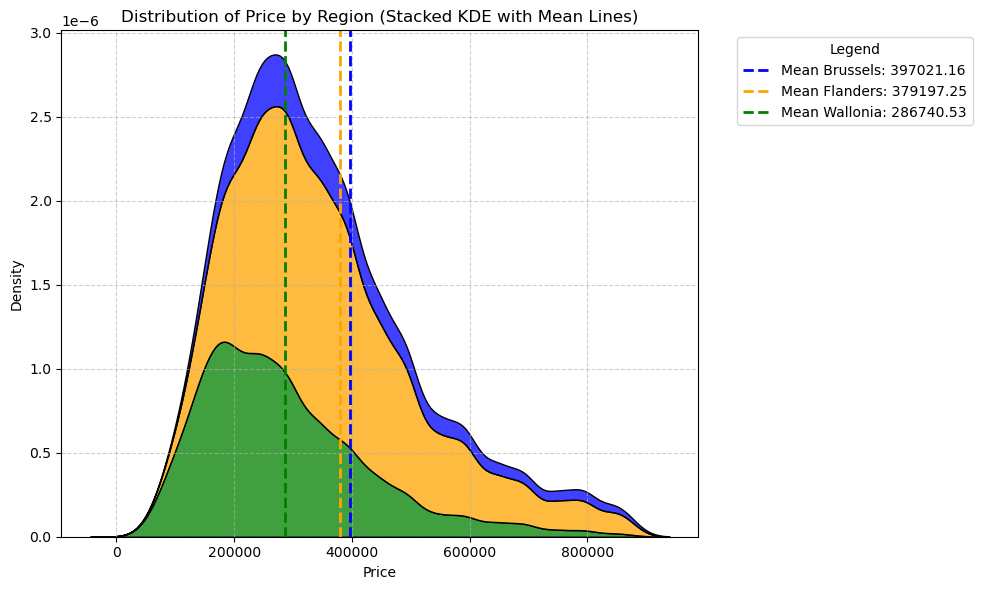

In [157]:
unique_provinces = sorted(df_cleaned['province'].unique())

# Define a custom palette mapping provinces to desired colors
province_colors = {
    unique_provinces[0]: 'blue',
    unique_provinces[1]: 'orange',
    unique_provinces[2]: 'green',
}

plt.figure(figsize=(10, 6)) # This creates the single graph/figure

# 1. Create the main stacked KDE plot
sns.kdeplot(data=df_cleaned, x="price", hue="province", multiple="stack", palette=province_colors, fill=True)

# 2. Calculate means for each province
mean_prices = df_cleaned.groupby('province')['price'].mean()

# 3. Add mean lines for each province
for province, mean_price in mean_prices.items():
    line_color = province_colors.get(province, 'gray') # Get color from palette
    plt.axvline(mean_price,
                color=line_color,
                linestyle='--',
                linewidth=2,
                label=f'Mean {province}: {mean_price:.2f}')

plt.title("Distribution of Price by Region (Stacked KDE with Mean Lines)")
plt.xlabel("Price")
plt.ylabel("Density")

# Manually combine legends to ensure clarity for KDE areas and mean lines
handles, labels = plt.gca().get_legend_handles_labels()

# Separate the KDE legend items from the mean line items
kde_handles = [h for h, l in zip(handles, labels) if "Mean" not in l]
kde_labels = [l for h, l in zip(handles, labels) if "Mean" not in l]

mean_handles = [h for h, l in zip(handles, labels) if "Mean" in l]
mean_labels = [l for h, l in zip(handles, labels) if "Mean" in l]

# Sort the mean labels for consistent legend order
sorted_mean_items = sorted(zip(mean_labels, mean_handles))
sorted_mean_labels = [label for label, handle in sorted_mean_items]
sorted_mean_handles = [handle for label, handle in sorted_mean_items]

# Combine and create the legend outside the plot area
plt.legend(kde_handles + sorted_mean_handles, kde_labels + sorted_mean_labels,
           title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

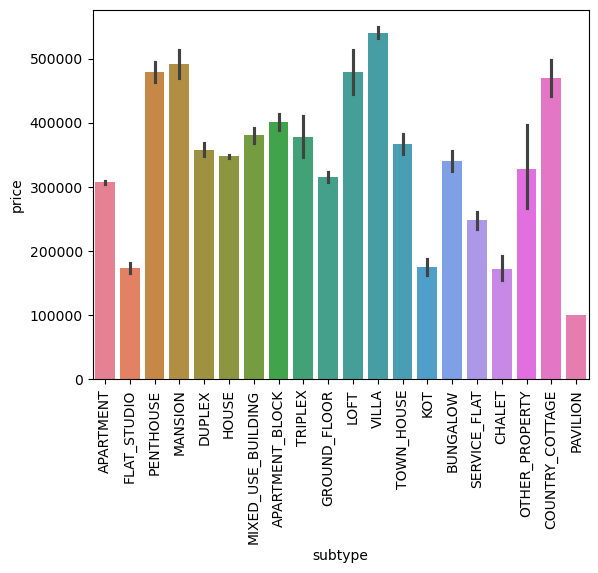

In [ ]:

sns.barplot(data=df_cleaned, x="subtype", y="price", hue="subtype")
plt.xticks(rotation=90)
plt.show()

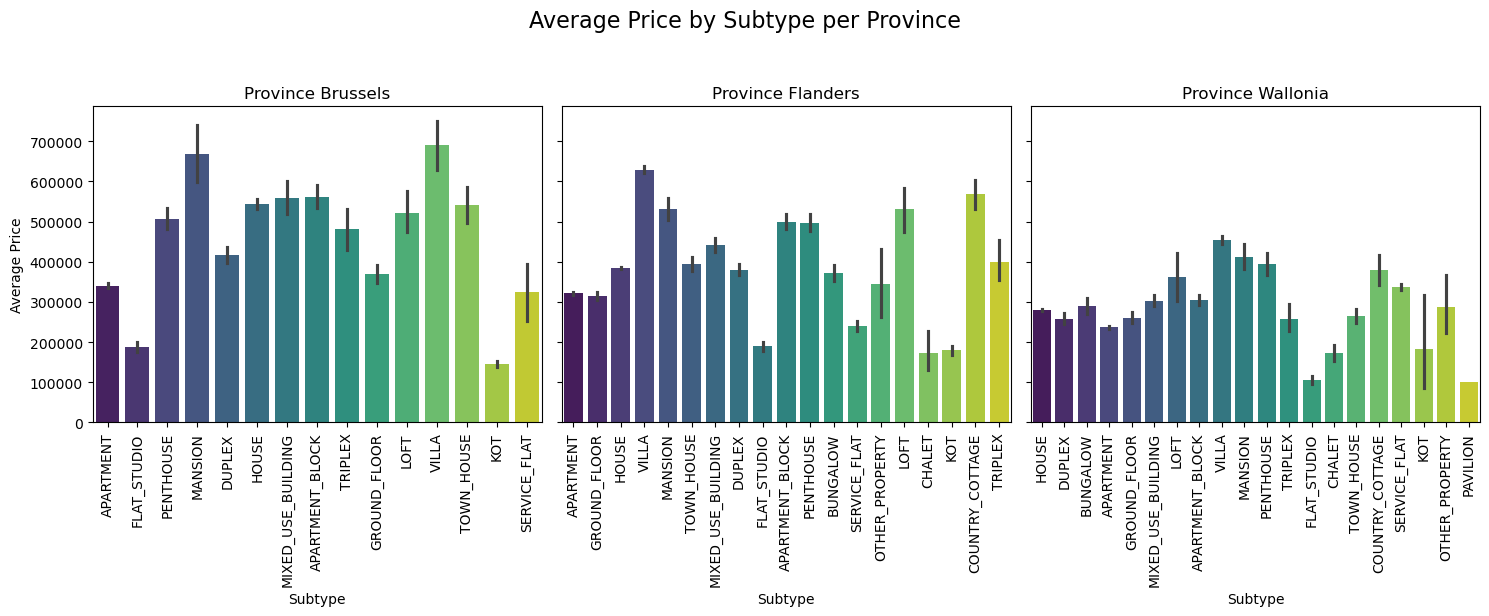

In [154]:

# Get unique provinces
unique_provinces = df_cleaned['province'].unique()
num_provinces = len(unique_provinces)

# Create a figure and a set of subplots arranged in a single row
# Adjust figsize as needed based on the number of provinces and subtypes
fig, axes = plt.subplots(1, num_provinces, figsize=(num_provinces * 5, 6), sharey=True) # sharey for consistent y-axis

# Ensure 'axes' is an array even if there's only one subplot (e.g., if num_provinces is 1)
if num_provinces == 1:
    axes = [axes]

# Iterate through each province and create a subplot
for i, province in enumerate(unique_provinces):
    ax = axes[i] # Select the current subplot

    # Filter data for the current province
    province_data = df_cleaned[df_cleaned['province'] == province]

    # Create the bar plot on the current subplot
    sns.barplot(data=province_data, x="subtype", y="price", hue="subtype", palette='viridis', dodge=False, ax=ax)

    ax.set_title(f"Province {province}") # Set subplot title
    ax.set_xlabel("Subtype")

    # Only show y-label for the first subplot
    if i == 0:
        ax.set_ylabel("Average Price")
    else:
        ax.set_ylabel("") # Remove y-label for subsequent subplots if sharey is True

    ax.tick_params(axis='x', rotation=90) # Rotate x-axis labels on the current subplot
   # ax.legend_.remove() # Remove the redundant hue legend from each subplot

# Add a super title for the entire figure (optional)
fig.suptitle("Average Price by Subtype per Province", y=1.02, fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent titles/labels from overlapping
plt.show()